# Test Spot2vector on the Mouse Brain 10X Visium data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

## Import data

In [2]:
adatast = sc.read_h5ad('./data/MouseBrain/preprocess_MouseBrain.h5ad')
adatast

AnnData object with n_obs × n_vars = 2688 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster', 'Ground Truth', 'domain_annotation'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
n_clusters = 15

In [4]:
sc.pp.pca(adatast, n_comps=10)

## Run Spot2vector

In [5]:
import Spot2Vector

Spot2Vector.Build_Graph(adatast, radius_cutoff=150, cutoff_type='radius', graph_type='spatial')
Spot2Vector.Build_Graph(adatast, neighbors_cutoff=8, cutoff_type='neighbors', graph_type='expression')

The spatial KNN grpah contains 2688 nodes and 15580.0 edges.(except self-loop)
Average degree of spatial graph: 5.80.
The expression KNN grpah contains 2688 nodes and 21504.0 edges.(except self-loop)
Average degree of expression graph: 8.00.


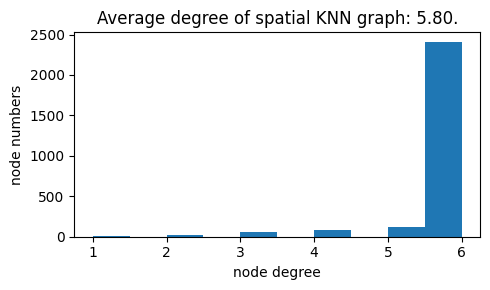

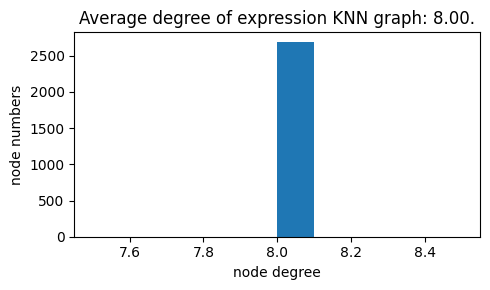

In [6]:
Spot2Vector.Graph_Stat_Plot(adatast)

In [7]:
device = 'cuda:0'
Spot2Vector.Fit(adatast, verbose=False, seed=10, device=device, max_epochs_st=1000)

Training: 100%|██████████| 1000/1000 [03:34<00:00,  4.66epoch/s, epoch=999, loss=0.492, lr=0.0001]


<Axes: xlabel='epoch', ylabel='loss_total'>

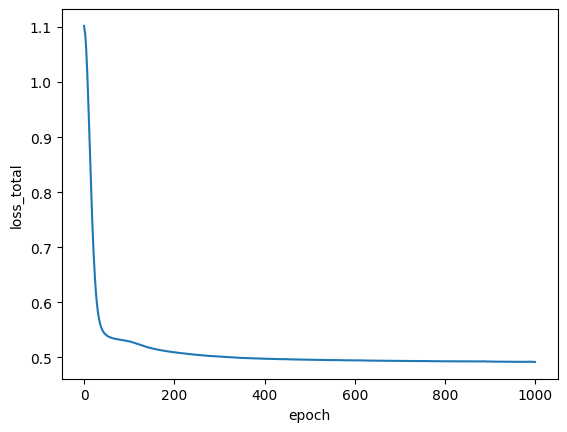

In [8]:
sns.lineplot(adatast.uns['training_history_df_st'], x = 'epoch', y='loss_total')

## Clustering

In [9]:
clust_method = 'mclust'

In [10]:
Spot2Vector.Clustering(adatast, obsm_data='exp_embeddings', method=clust_method, n_cluster=n_clusters, verbose=False)
Spot2Vector.Clustering(adatast, obsm_data='spa_embeddings', method=clust_method, n_cluster=n_clusters, verbose=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


In [11]:
# lamda = 1 for expression, lamda = 0 for spatial
Spot2Vector.Infer(adatast, lamda=0.4, device=device)

In [12]:
Spot2Vector.Clustering(adatast, obsm_data='embeddings', method=clust_method, n_cluster=n_clusters, verbose=False)

fitting ...
  |======================================================================| 100%


In [13]:
Spot2Vector.Clustering_Metrics(adatast, f'embeddings_{clust_method}')

ARI of embeddings_mclust is: 0.701755168512107
NMI of embeddings_mclust is: 0.7922065309578706


## Visualization

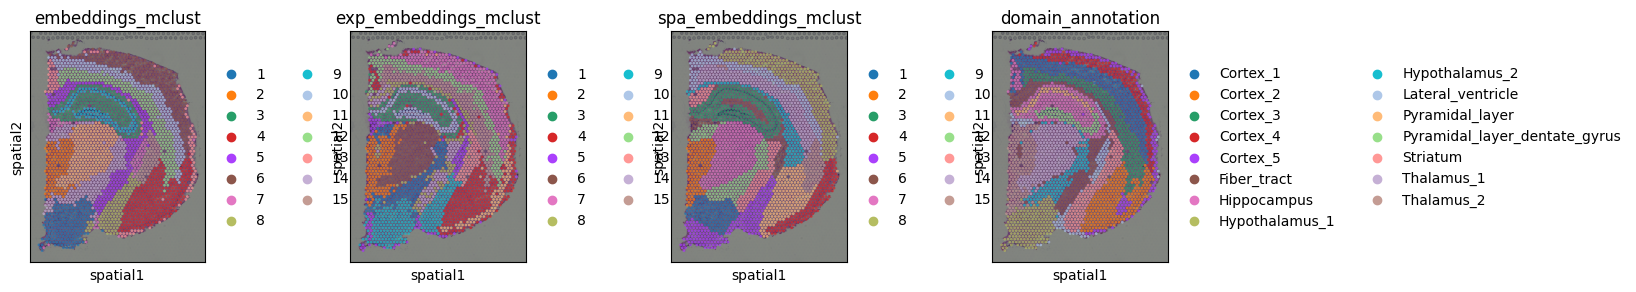

In [14]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adatast,
              color=[f"embeddings_{clust_method}",
                     f"exp_embeddings_{clust_method}", 
                     f"spa_embeddings_{clust_method}", 
                     "domain_annotation"], 
              title=[f"embeddings_{clust_method}",
                     f"exp_embeddings_{clust_method}", 
                     f"spa_embeddings_{clust_method}", 
                     "domain_annotation"], 
              size=1.3, 
              alpha=0.7)

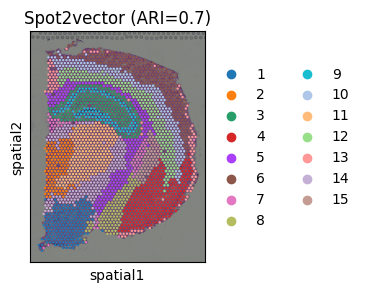

In [15]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adatast, color=f"embeddings_{clust_method}", 
              title='Spot2vector (ARI=' + str(np.round(adatast.uns['embeddings_mclust_ARI'], 2)) + ')',
              spot_size=100,
              save='MouseBrain_Spot2vector.svg')